In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, tqdm_notebook

# Graph Convolutions on Pandas

## What's going on?

Here is an example how simple graph convolutions can be made using the power of table frameworks like pandas. There are several ways to define a convolution on graph data. Here graph convolutions are treated as a simple aggregation of neighbors for each vertex.

Step by step:
1. get all neighbors for each node
2. apply a pooling function to the list of neigbors
3. repeat if you need

In this example we are given edges dataframe and nodes features. Mean function is used as a pooling. Example function is common enough, so it can be easily used for bipartite graphs. It also suitable for large graphs due to chunking.

## Why?
For the glory of Satan of course!  
There are a lot of cool approaches with a lot of math behind them, but most of that approaches will not work with huge graphs. Table frameworks that are able to join, groupby and aggregate give us the great power to make graph convolutions feasible at large scales.

In [1]:
def chunker(seq, size):
    """https://stackoverflow.com/a/434328"""
    return (seq[pos: pos + size] for pos in range(0, len(seq), size))

def make_conv(edges, feats, cols, by, on, size=1000000, agg_f='mean',
                      prefix='mean_'):
    """
    edges -- edgelist: pandas dataframe with two columns (arguments by and on)
    feats -- features dataframe with key column (argument on) 
             and features columns (argument cols)
    by -- column in edges to be used as source nodes
    on -- column in edges to be used as neighbor nodes
    size -- number of unique source nodes to be used in one chunk
    agg_f -- can be interpreted as pooling function. 
             Pandas has several optimised functions for basic statistics,
             that can be passed as string arg (see pandas docs),
             but you also can provide any function you like
    prefix -- prefix for new column names             
    """
    res_feats = [] # used to stack result chunks

    # get chunk of unique source nodes
    for chunk in tqdm(chunker(edges[by].unique(), size=size), 
                      total=(len(edges[by].unique()) // size) + 1):
        # for each chunk we get feature matrix for neighbours
        temp = edges[edges[by].isin(chunk)]\
                .merge(feats, on=on, how='left')
        # convolve and pool
        tempgb = temp[cols + [by, on]]\
                .groupby(by).agg({col: agg_f for col in cols}).reset_index()
        res_feats.append(tempgb.rename(columns={c: prefix + c for c in cols}))
    # concat results
    return pd.concat(res_feats, axis=0).reset_index(drop=True)

Make simple graph: 101 nodes, each connected with two neighbors. Simply chain of nodes.

In [3]:
ara = np.arange(101).reshape(-1, 1)
sample = np.vstack((np.hstack((ara[:-1], ara[1:])), # forward links
                    np.hstack((ara[1:], ara[:-1])))) # backward links

Make random features

In [4]:
feats = np.random.normal(size=(101, 10))

Create dataframes from arrays

In [6]:
edges = pd.DataFrame(sample, columns=['source', 'target'])
cols = ['col{}'.format(i) for i in range(10)]
feats = pd.DataFrame(feats, columns=cols)
feats['target'] = ara

This is how the feature matrix looks like

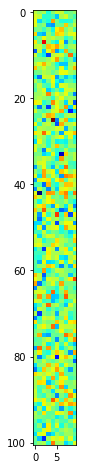

In [15]:
plt.figure(figsize=(3, 8))
plt.imshow(feats.values[:, :-1], cmap='jet');

## First convolution

In [7]:
conv1 = make_conv(edges, feats, cols, 'source', 'target')

100%|██████████| 1/1 [00:00<00:00, 67.25it/s]


In [8]:
conv1.head()

,source,mean_col0,mean_col1,mean_col2,mean_col3,mean_col4,mean_col5,mean_col6,mean_col7,mean_col8,mean_col9
0,0,0.730085,0.428604,-0.967305,-0.927957,-0.648321,-1.529437,0.288742,0.642841,-0.240322,-0.686550
1,1,0.651642,-0.683116,-0.179200,-1.069835,0.824370,0.202663,-0.247970,-0.769478,-0.604019,0.006299
2,2,0.749263,0.077546,-0.472234,-1.326084,-1.266701,-0.928092,0.004736,0.990368,-0.250484,-0.116420
3,3,0.284014,-0.788309,-0.719696,-0.625851,0.258956,0.450587,0.204037,-0.627669,-0.277296,-0.296346
4,4,1.012357,-0.862818,-0.838706,-0.779575,-1.250686,0.492440,0.426747,0.723831,0.232588,0.665481


First 10 columns are raw nodes features, next 10 are smoothed between neighbors. It's the same as box blur in image processing.

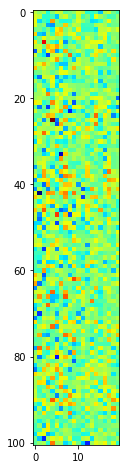

In [9]:
plt.figure(figsize=(3, 8))
plt.imshow(np.hstack((feats[cols].values,
                      conv1.values[:, 1:])), cmap='jet');

In [10]:
conv1.head()

,source,mean_col0,mean_col1,mean_col2,mean_col3,mean_col4,mean_col5,mean_col6,mean_col7,mean_col8,mean_col9
0,0,0.730085,0.428604,-0.967305,-0.927957,-0.648321,-1.529437,0.288742,0.642841,-0.240322,-0.686550
1,1,0.651642,-0.683116,-0.179200,-1.069835,0.824370,0.202663,-0.247970,-0.769478,-0.604019,0.006299
2,2,0.749263,0.077546,-0.472234,-1.326084,-1.266701,-0.928092,0.004736,0.990368,-0.250484,-0.116420
3,3,0.284014,-0.788309,-0.719696,-0.625851,0.258956,0.450587,0.204037,-0.627669,-0.277296,-0.296346
4,4,1.012357,-0.862818,-0.838706,-0.779575,-1.250686,0.492440,0.426747,0.723831,0.232588,0.665481


## Second convolution

In [11]:
cols = list(conv1.columns)[1:]
conv2 = make_conv(edges, conv1.rename(columns={'source': 'target'}), cols, 'source', 'target')

100%|██████████| 1/1 [00:00<00:00, 80.04it/s]


In [12]:
conv2.shape

(101, 11)

First convolution features contains information about neighbors. Second step features contains information about neigbors of neighbors.

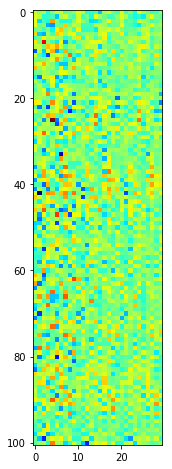

In [13]:
plt.figure(figsize=(3, 8))
plt.imshow(np.hstack((feats.values[:, :-1],
                      conv1.values[:, 1:],
                      conv2.values[:, 1:])), cmap='jet');